<a href="https://colab.research.google.com/github/Brilliyandddd/PCVK/blob/main/Kuis_2_PCVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kelompok 2

1. Agung Afrizal Daffa (2141720110)
2. Brilliyand Noval Herdana Putra (2141720104)
3. Muhammad Islahuddin (2141720268)

1. Mengerjakan secara kelompok yang terdiri dari 3 anggota
2. Kumpulkan e-ktp anggota keluarga pada kelompok minimal 10 buah sebagai dataset.
3. deteksi dan kenali foto wajah e-ktp tersebut menggunakan metode yang telah dipelajari baik pada matakulilah PCVK ataupun matakuliah lain pada semester ini.
4. Presentasikan di depan kelas hasil dari pekerjaan kelompok Anda, paparkan hasil dari pekerjaan tersebut secara detail lengkap dengan tangkapan layar bagian dari; (1)pre-processing, (2)lokalisasi, (3)segmentasi, dan (4)pengenalan.
5. jangan lupa upload juga kode program tersebut pada repository
6. kumpulkan link file presentasi dalam bentuk pdf dan link repository.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
# img = cv2.imread('/content/drive/MyDrive/Halokes/DatasetPCVK/test.jpg')
img = cv2.imread('/content/drive/MyDrive/DatasetPCVK/1.jpg')
img_original = np.copy(img)

# Apply Gaussian Blur
blurred_img = cv2.GaussianBlur(img_original, (5, 5), 0.5)

# Apply Erosion
kernel_erosion = np.ones((3, 3), np.uint8)
eroded_img = cv2.erode(blurred_img, kernel_erosion, iterations=1)

# Apply Dilation
kernel_dilation = np.ones((5, 5), np.uint8)
dilated_img = cv2.dilate(eroded_img, kernel_dilation, iterations=10)

# Apply Opening (Erosion followed by Dilation)
kernel_opening = np.ones((5, 5), np.uint8)
opening_img = cv2.morphologyEx(dilated_img, cv2.MORPH_OPEN, kernel_opening)

gray = cv2.cvtColor(opening_img, cv2.COLOR_BGR2GRAY)

# Otsu Thresholding
_, otsu_thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


In [4]:
# Lokalisasi (Canny)
edged = cv2.Canny(otsu_thresholded, 50, 150)

In [5]:
# Segmentasi

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
biggest = biggest_contour(contours)
cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)

# Warp Prespective
points = biggest.reshape(4, 2)
input_points = np.zeros((4, 2), dtype="float32")

points_sum = points.sum(axis=1)
input_points[0] = points[np.argmin(points_sum)]
input_points[3] = points[np.argmax(points_sum)]

points_diff = np.diff(points, axis=1)
input_points[1] = points[np.argmin(points_diff)]
input_points[2] = points[np.argmax(points_diff)]

(top_left, top_right, bottom_right, bottom_left) = input_points
bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

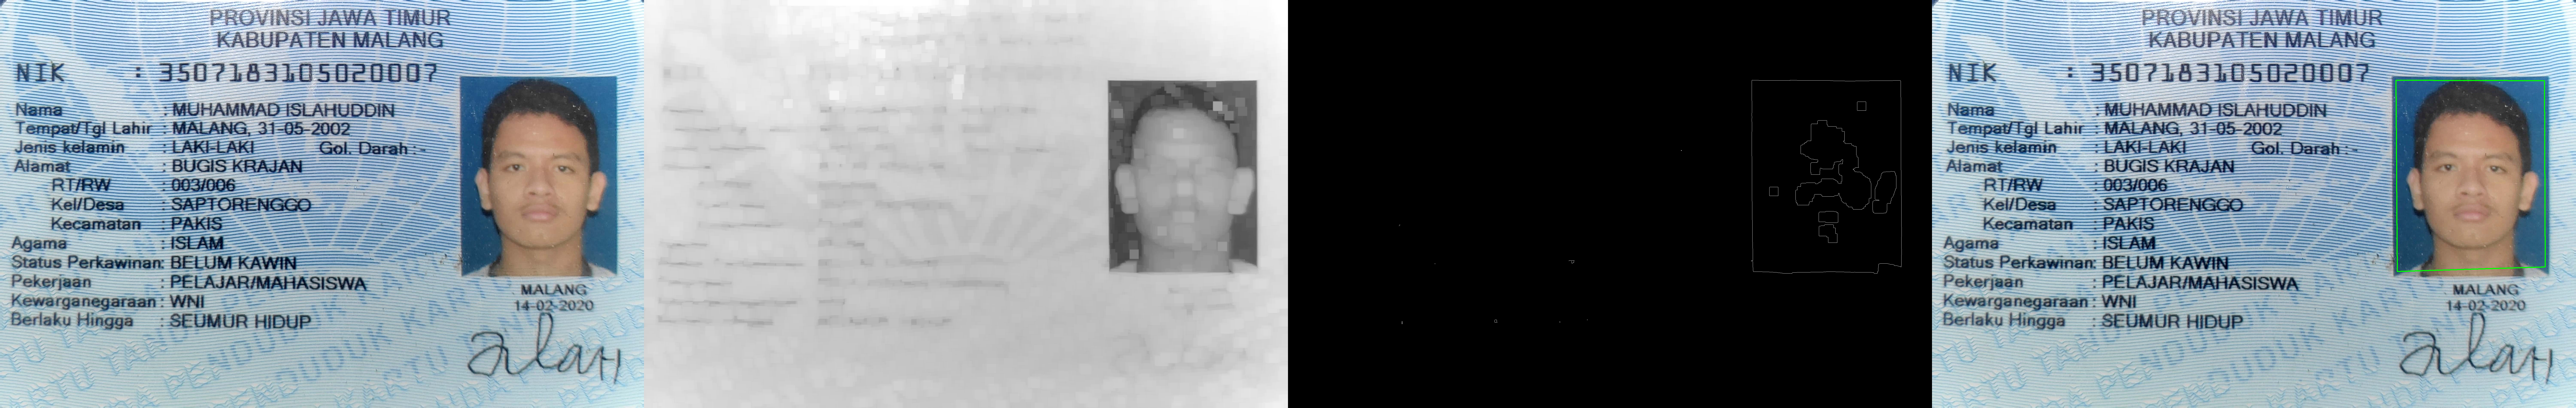

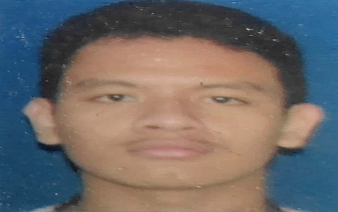

In [6]:
# Output gambar setelah Warp Prespective
ktp_width = 8.6  # Lebar KTP dalam cm
ktp_height = 5.4  # Tinggi KTP dalam cm

max_width = int(ktp_width * 100 / 2.54)
max_height = int(ktp_height * 100 / 2.54)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

# Image shape modification for hstack
gray = np.stack((gray,) * 3, axis=-1)
edged = np.stack((edged,) * 3, axis=-1)

img_hor = np.hstack((img_original, gray, edged, img))
cv2_imshow(img_hor)
cv2_imshow(img_output)